In [416]:
#pip install category_encoders
#pip install pygini
#pip install feature_engine
#pip install scikit-optimize 

import pandas as pd
import seaborn as sns
import numpy as np
import math
import sklearn
from numpy import percentile
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from scipy.stats import ks_2samp, kstest
from matplotlib import pyplot as plt
from feature_engine.encoding import RareLabelEncoder
from category_encoders.woe import WOEEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.isotonic import IsotonicRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from pygini import gini
from skopt import BayesSearchCV

import warnings

In [417]:
def data_outlier(columns_list, data):
    """Функция определяет выбросы признаков и строит датафрейм"""

    data_out = pd.DataFrame(data={'name': [], 'low_range': [], 
                                  'upper_range': [], 'out_count': []})
    df_copy = data.copy()
    
    for column_name in columns_list:
        perc25 = percentile(df_copy[column_name].dropna(axis=0), 25)
        perc75 = percentile(df_copy[column_name].dropna(axis=0), 75)
        iqr = perc75 - perc25
        low_range = perc25 - 1.5 * iqr
        upper_range = perc75 + 1.5 * iqr
        out_count = df_copy.loc[((df_copy[column_name] < low_range) | 
                                 (df_copy[column_name] > upper_range)), column_name].count()

        to_append = [column_name, round(low_range, 2), round(upper_range, 2), out_count]
        data_out_length = len(data_out)
        data_out.loc[data_out_length] = to_append

    data_out = data_out.set_index('name')

    return data_out

In [418]:
def variable_analyze(var, number_type, data):
    
    outlier_df = data_outlier(number_type, df)
    
    if df[var].dtype == 'object':
        zero_sum = df.loc[(df[var]==''), var].count()
        null_sum = df[var].isna().sum()
        
        print(f'Количество пустых строк у признака: {zero_sum}')
        print(f'Количество null значений у признака: {null_sum}')
        
    else:
        null_sum = df[var].isna().sum()
        
        print(f'Количество null значений у признака: {null_sum}\n')
        print(f'Выбросы признака: \n{outlier_df.loc[var]}')

In [419]:
def variable_hist_plot(var, data):
    
    df_copy = data.copy()
    
    if df[var].dtype == 'object':
        plt.figure(figsize=(5,7))
        sns.countplot(y=var, data=df_copy, hue='Credit Default', order=df_copy[var].value_counts().index)
        plt.show()
        
        
    else:
        #Создаем логарифмическую переменную от исходной
        var_log = var +'_log'
        df_copy[var_log] = np.log(df_copy[var] + 1)
        
        plt.figure(figsize=(15,5))
        sns.histplot(x=var, data=df_copy, hue='Credit Default', multiple="stack")
        plt.show()     
        
        plt.figure(figsize=(15,5))
        sns.histplot(x=var_log, data=df_copy, hue='Credit Default', multiple="stack")
        plt.show() 

In [420]:
# интервальный Джини
def interval_gini(prb_list):
    """Функция считает значение Джини на 1000 бустреп выборках из 100 элементов и записывает значения в список"""
    gini_values = []
    
    for x in range(1000):
        gini_x = gini(np.random.choice(prb_list, size=100))
        gini_values.append(gini_x)
    
    return gini_values

In [421]:
# КС тест
def model_ks_test(model_prb, data):
    """Функция строит распределение кумулятивной функции скоринга и выводит значение тест КС"""
    
    data_copy = pd.DataFrame(zip(data['Credit Score'],model_prb), columns=['Scoring', 'probab_default'])
    data_copy['default'] = data_copy['probab_default'].apply(lambda x: 1 if x >= 0.5 else 0)
    
    good_clients = data_copy.loc[(data_copy['default']==0), 'Scoring'].value_counts().sort_index()
    bad_clients = data_copy.loc[(data_copy['default']==1), 'Scoring'].value_counts().sort_index()
    
    scoring_list = []
    for x in range(400, 1000):
        scoring_list.append([x, good_clients.get(x, 0), bad_clients.get(x, 0)])
    
    df_scoring = pd.DataFrame(scoring_list, columns=['Scoring', 'good_count', 'bad_count'])
    df_scoring['good_cumsum'] = np.cumsum(df_scoring['good_count'])
    df_scoring['bad_cumsum'] = np.cumsum(df_scoring['bad_count'])   
    df_scoring['good_cumsum_perc'] = round(df_scoring['good_cumsum'] / df_scoring['good_count'].sum() * 100, 2)
    df_scoring['bad_cumsum_perc'] = round(df_scoring['bad_cumsum'] / df_scoring['bad_count'].sum() * 100, 2)
    
    plt.figure(figsize=(10,5))
    sns.lineplot(data=df_scoring, x='Scoring', y='good_cumsum_perc')
    sns.lineplot(data=df_scoring, x='Scoring', y='bad_cumsum_perc')
    plt.show()
    
    return ks_2samp(df_scoring['good_cumsum_perc'], df_scoring['bad_cumsum_perc'])

In [422]:
def calculate_psi(expected, actual, buckettype='bins', buckets=10, axis=0):
    '''Calculate the PSI (population stability index) across all variables
    Args:
       expected: numpy matrix of original values
       actual: numpy matrix of new values, same size as expected
       buckettype: type of strategy for creating buckets, bins splits into even splits, quantiles splits into quantile buckets
       buckets: number of quantiles to use in bucketing variables
       axis: axis by which variables are defined, 0 for vertical, 1 for horizontal
    Returns:
       psi_values: ndarray of psi values for each variable
    Author:
       Matthew Burke
       github.com/mwburke
       worksofchart.com
    '''

    def psi(expected_array, actual_array, buckets):
        '''Calculate the PSI for a single variable
        Args:
           expected_array: numpy array of original values
           actual_array: numpy array of new values, same size as expected
           buckets: number of percentile ranges to bucket the values into
        Returns:
           psi_value: calculated PSI value
        '''

        def scale_range (input, min, max):
            input += -(np.min(input))
            input /= np.max(input) / (max - min)
            input += min
            return input


        breakpoints = np.arange(0, buckets + 1) / (buckets) * 100

        if buckettype == 'bins':
            breakpoints = scale_range(breakpoints, np.min(expected_array), np.max(expected_array))
        elif buckettype == 'quantiles':
            breakpoints = np.stack([np.percentile(expected_array, b) for b in breakpoints])



        expected_percents = np.histogram(expected_array, breakpoints)[0] / len(expected_array)
        actual_percents = np.histogram(actual_array, breakpoints)[0] / len(actual_array)

        def sub_psi(e_perc, a_perc):
            '''Calculate the actual PSI value from comparing the values.
               Update the actual value to a very small number if equal to zero
            '''
            if a_perc == 0:
                a_perc = 0.0001
            if e_perc == 0:
                e_perc = 0.0001

            value = (e_perc - a_perc) * np.log(e_perc / a_perc)
            return(value)

        psi_value = np.sum(sub_psi(expected_percents[i], actual_percents[i]) for i in range(0, len(expected_percents)))

        return(psi_value)

    if len(expected.shape) == 1:
        psi_values = np.empty(len(expected.shape))
    else:
        psi_values = np.empty(expected.shape[axis])

    for i in range(0, len(psi_values)):
        if len(psi_values) == 1:
            psi_values = psi(expected, actual, buckets)
        elif axis == 0:
            psi_values[i] = psi(expected[:,i], actual[:,i], buckets)
        elif axis == 1:
            psi_values[i] = psi(expected[i,:], actual[i,:], buckets)

    return(psi_values)

In [423]:
def model_calibr_curve(model_name, model_prb, y_test, X_val, y_val):
    """Функция считает изотоническую калибровку для модели и выводит график сравнения"""

    #IsotonicRegression
    isotonic_regress = IsotonicRegression(y_min = 0, y_max = 1, out_of_bounds = 'clip').fit(model_prb, y_test)
    prb_isotonic_regress = isotonic_regress.predict(model_name.predict_proba(X_val)[:, 1])

    #Создаем calibration_curve для моделей для сравнения
    prob_true_model, prob_pred_model = calibration_curve(y_test, model_prb, n_bins=10)
    prob_true_iso, prob_pred_iso = calibration_curve(y_val, prb_isotonic_regress, n_bins=10)
    
    #Строим график
    plt.figure(figsize=(7,7))
    plt.plot([0,1], [0,1], color='grey')
    plt.plot(prob_pred_model, prob_true_model, marker='o', label=model_name)
    plt.plot(prob_pred_iso, prob_true_iso, marker='o', label='iso_model')
    plt.xlabel('Predicted probability')
    plt.ylabel('True probability in each bin')
    plt.show()

In [424]:
warnings.simplefilter("ignore")
RANDOM_SEED = 42

In [425]:
df = pd.read_csv('C:/Users/Files/GB_AA_DataScience/AA_test/train.csv')

In [426]:
df.sample(10)

,Id,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
4227,4227,Rent,474392.0,6 years,0.0,8.0,13.7,127446.0,0.0,NaN,0.0,debt consolidation,Short Term,164230.0,106894.0,4190.0,645.0,0
2179,2179,Rent,1724193.0,9 years,0.0,10.0,16.8,889614.0,0.0,NaN,0.0,debt consolidation,Long Term,443652.0,437931.0,22414.0,687.0,0
4871,4871,Rent,565326.0,1 year,0.0,5.0,14.6,307824.0,0.0,NaN,0.0,debt consolidation,Short Term,225830.0,155249.0,8103.0,746.0,1
7126,7126,Rent,1829548.0,2 years,0.0,8.0,20.3,276496.0,0.0,40.0,0.0,debt consolidation,Long Term,356796.0,165243.0,23022.0,694.0,0
2944,2944,Rent,941450.0,10+ years,0.0,6.0,19.7,632852.0,0.0,NaN,0.0,debt consolidation,Long Term,479644.0,100567.0,10670.0,712.0,0
1084,1084,Home Mortgage,1039110.0,3 years,0.0,7.0,22.8,98868.0,0.0,78.0,0.0,debt consolidation,Short Term,171886.0,49191.0,11690.0,737.0,0
2506,2506,Home Mortgage,NaN,10+ years,0.0,6.0,23.0,198946.0,0.0,NaN,0.0,medical bills,Long Term,223454.0,90193.0,6208.0,NaN,0
7434,7434,Home Mortgage,3217080.0,< 1 year,0.0,14.0,23.6,447326.0,1.0,NaN,1.0,debt consolidation,Short Term,315524.0,124792.0,30294.0,739.0,0
7322,7322,Rent,NaN,2 years,0.0,13.0,22.9,448690.0,1.0,NaN,1.0,debt consolidation,Short Term,315700.0,277077.0,11490.0,NaN,1
773,773,Home Mortgage,610679.0,1 year,0.0,16.0,20.0,294030.0,0.0,9.0,0.0,home improvements,Short Term,145838.0,115292.0,9160.0,738.0,1


In [427]:
df.shape

(7500, 18)

In [428]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Id                            7500 non-null   int64  
 1   Home Ownership                7500 non-null   object 
 2   Annual Income                 5943 non-null   float64
 3   Years in current job          7129 non-null   object 
 4   Tax Liens                     7500 non-null   float64
 5   Number of Open Accounts       7500 non-null   float64
 6   Years of Credit History       7500 non-null   float64
 7   Maximum Open Credit           7500 non-null   float64
 8   Number of Credit Problems     7500 non-null   float64
 9   Months since last delinquent  3419 non-null   float64
 10  Bankruptcies                  7486 non-null   float64
 11  Purpose                       7500 non-null   object 
 12  Term                          7500 non-null   object 
 13  Cur

In [429]:
df.describe()

,Id,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,7500.000000,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,3749.500000,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,2165.207842,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,0.000000,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,1874.750000,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,3749.500000,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,5624.250000,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,7499.000000,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [430]:
# Посмотрим количество уникальных значений
df.nunique()

Id                              7500
Home Ownership                     4
Annual Income                   5478
Years in current job              11
Tax Liens                          8
Number of Open Accounts           39
Years of Credit History          408
Maximum Open Credit             6963
Number of Credit Problems          8
Months since last delinquent      89
Bankruptcies                       5
Purpose                           15
Term                               2
Current Loan Amount             5386
Current Credit Balance          6592
Monthly Debt                    6716
Credit Score                     268
Credit Default                     2
dtype: int64

## Рассмотрим все признаки

Распределим признаки начально на бинарные, категориальные и числовые

Признак id не рассматриваем, удалим его

In [431]:
bin_var = ['Term']
categorial_var = ['Home Ownership', 'Years in current job', 'Tax Liens',
                  'Number of Credit Problems', 'Bankruptcies', 'Purpose']
number_var = df.columns.drop(['Id', 'Home Ownership', 'Tax Liens', 'Number of Credit Problems', 
                              'Years in current job', 'Bankruptcies', 'Purpose', 'Term', 'Credit Default']).to_list()

In [432]:
for x in [*bin_var, *categorial_var]:
    df[x] = df[x].astype('O')

In [433]:
df = df.drop('Id', axis=1)

#### Term

Количество пустых строк у признака: 0
Количество null значений у признака: 0


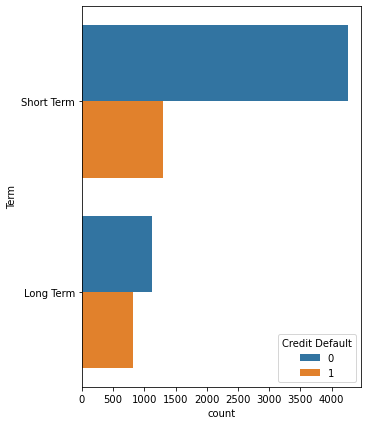

In [434]:
variable_analyze('Term', number_var, df)
variable_hist_plot('Term', df)

In [435]:
#Сделаем преобразование в бинарный тип
df['Term'] = df['Term'].apply(lambda x: 1 if x=='Short Term' else 0)

#### Home Ownership

In [436]:
df['Home Ownership'] = df['Home Ownership'].apply(lambda x: 'Home Mortgage' if x=='Have Mortgage' else x)

Количество пустых строк у признака: 0
Количество null значений у признака: 0


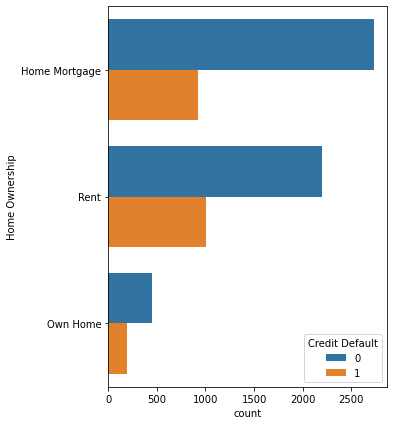

In [437]:
variable_analyze('Home Ownership', number_var, df)
variable_hist_plot('Home Ownership', df)

#### Years in current job

Количество пустых строк у признака: 0
Количество null значений у признака: 371


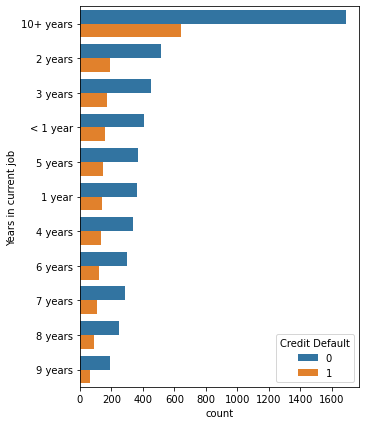

In [438]:
variable_analyze('Years in current job', number_var, df)
variable_hist_plot('Years in current job', df)

Замечание: Количество null Значений мало, либо удалим строки, либо сделаем преобразование

#### Tax Liens

Количество пустых строк у признака: 0
Количество null значений у признака: 0


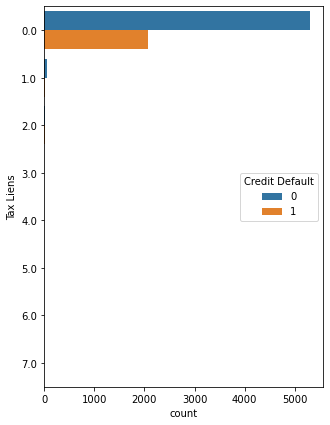

In [439]:
variable_analyze('Tax Liens', number_var, df)
variable_hist_plot('Tax Liens', df)

Замечание: 

    значение 0 имеет сильное преобладание над остальными значениями
    
    С помощью rare-encoder объединим редкие значения в одну группу

#### Number of Credit Problems

Количество пустых строк у признака: 0
Количество null значений у признака: 0


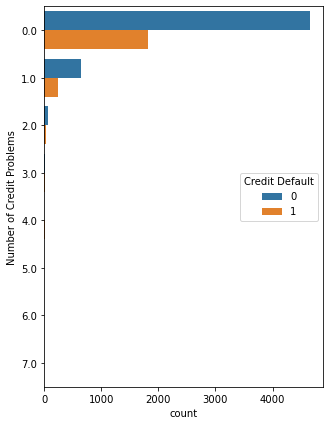

In [440]:
variable_analyze('Number of Credit Problems', number_var, df)
variable_hist_plot('Number of Credit Problems', df)

Замечание: 
   
    С помощью rare-encoder объединим редкие значения в одну группу

#### Bankruptcies

Количество пустых строк у признака: 0
Количество null значений у признака: 14


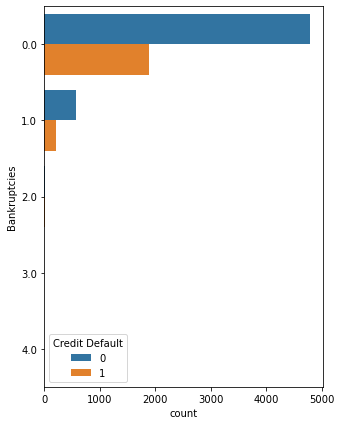

In [441]:
variable_analyze('Bankruptcies', number_var, df)
variable_hist_plot('Bankruptcies', df)

Замечание:
    
    Количество null значений невелико, скорее всего удалим 
    С помощью rare-encoder объединим редкие значения в одну группу

#### Purpose 

In [442]:
df['Purpose'] = df['Purpose'].apply(lambda x: 
                                    'business loan' if x=='small business' else 
                                    'purchase' if x in ['buy a car', 'buy house', 'major purchase'] else 
                                    'trip' if x in ['take a trip', 'vacation'] else x)

Количество пустых строк у признака: 0
Количество null значений у признака: 0


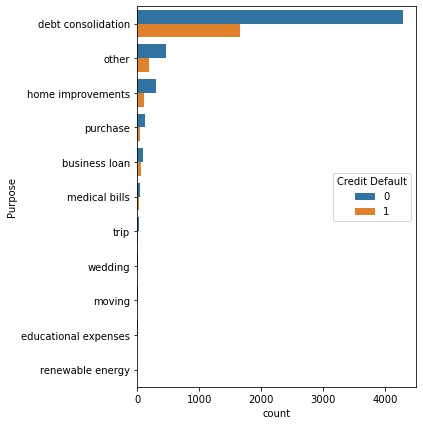

In [443]:
variable_analyze('Purpose', number_var, df)
variable_hist_plot('Purpose', df)

Замечание:

    С помощью rare-encoder объединим редкие значения в одну группу

### Рассмотрим признаки, которые имеют числовой тип

#### Annual Income

Количество null значений у признака: 1557

Выбросы признака: 
low_range      -349353.0
upper_range    2833831.0
out_count          287.0
Name: Annual Income, dtype: float64


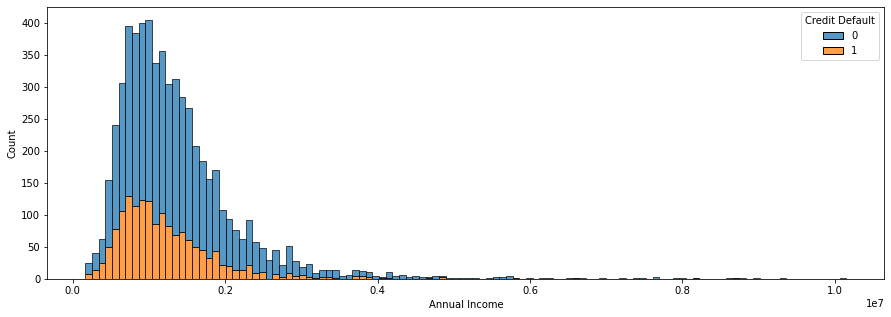

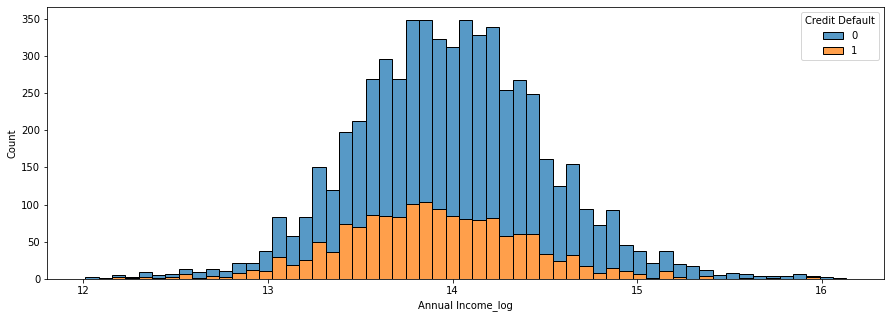

In [444]:
variable_analyze('Annual Income', number_var, df)
variable_hist_plot('Annual Income', df)

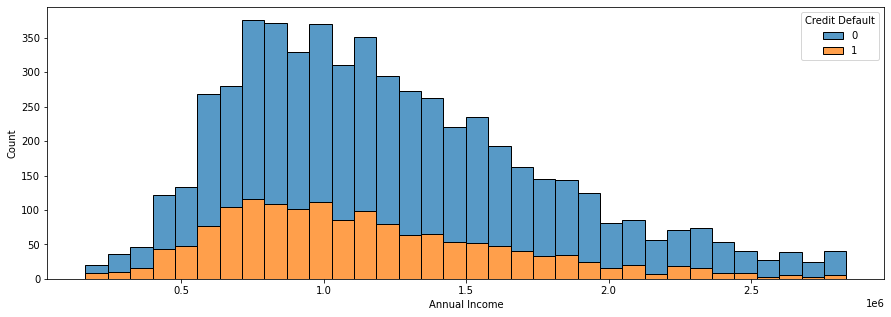

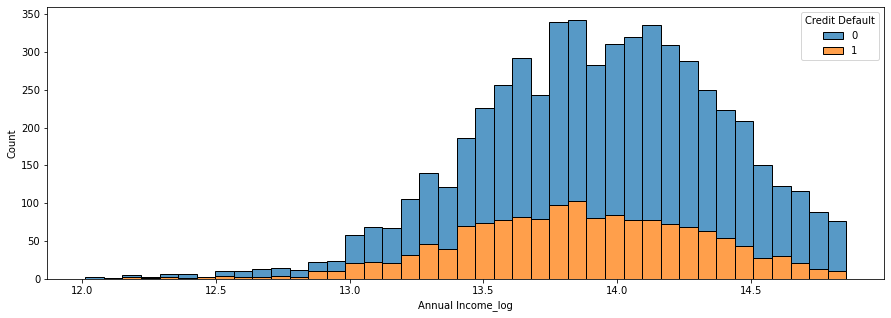

In [445]:
# Посмотрим распределение без выбросов
variable_hist_plot('Annual Income', df[df['Annual Income']<=2_833_831])

In [446]:
df['Annual Income log'] = np.log(df['Annual Income'] + 1)

Вывод:

    Количество null значений велико, либо удалим значения, либо сделаем преобразование
    Добавили новый признак с логарифмом

#### Years of Credit History

Количество null значений у признака: 0

Выбросы признака: 
low_range        1.05
upper_range     34.25
out_count      228.00
Name: Years of Credit History, dtype: float64


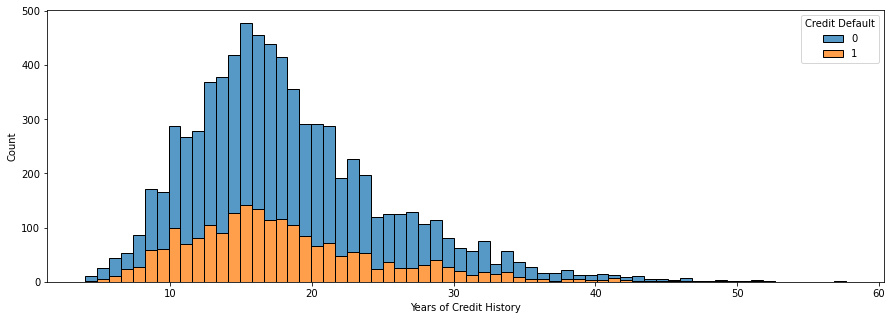

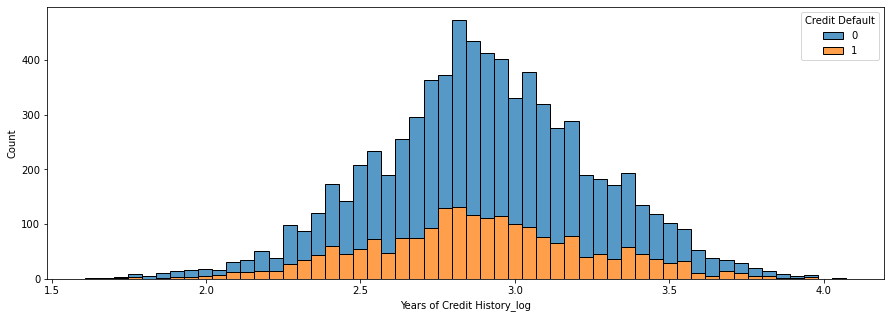

In [447]:
variable_analyze('Years of Credit History', number_var, df)
variable_hist_plot('Years of Credit History', df)

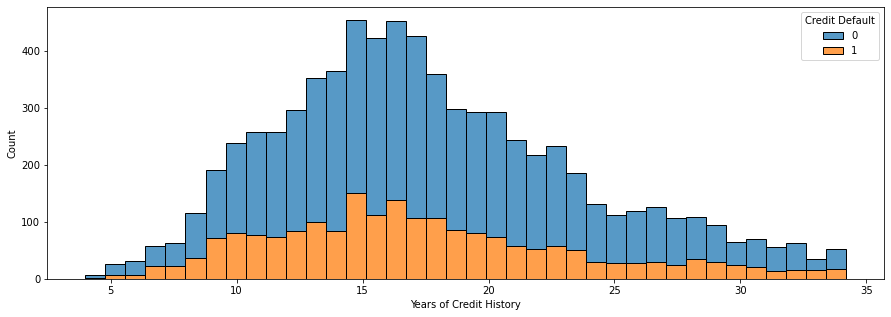

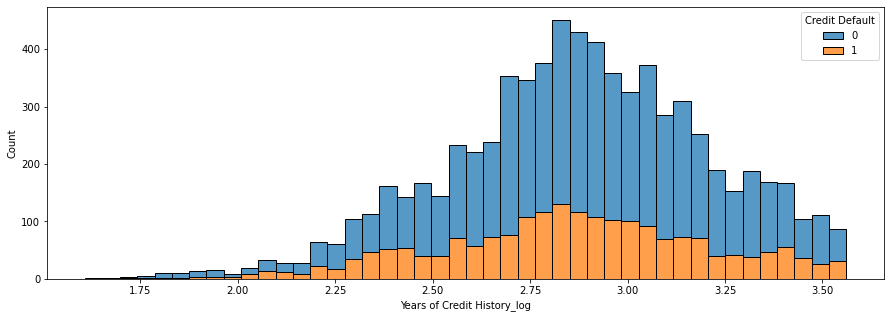

In [448]:
# Посмотрим распределение без выбросов
variable_hist_plot('Years of Credit History', df[(df['Years of Credit History']>=1.05) 
                                                 & (df['Years of Credit History']<=34.25)])

In [449]:
df['Years of Credit History log'] = np.log(df['Years of Credit History'] + 1)

Замечание:

    Сделали новый признак

#### Maximum Open Credit

Количество null значений у признака: 0

Выбросы признака: 
low_range      -492178.5
upper_range    1564909.5
out_count          466.0
Name: Maximum Open Credit, dtype: float64


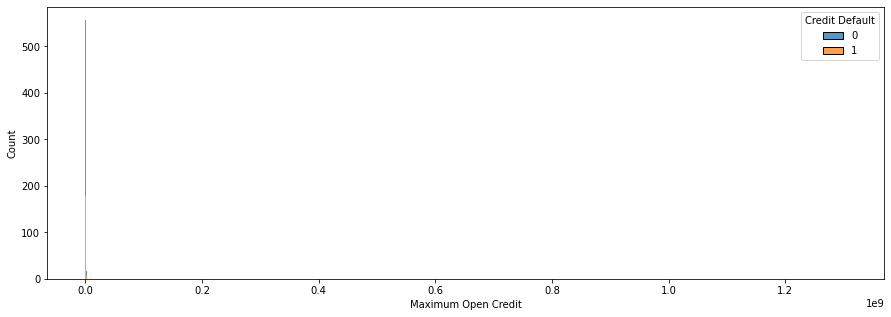

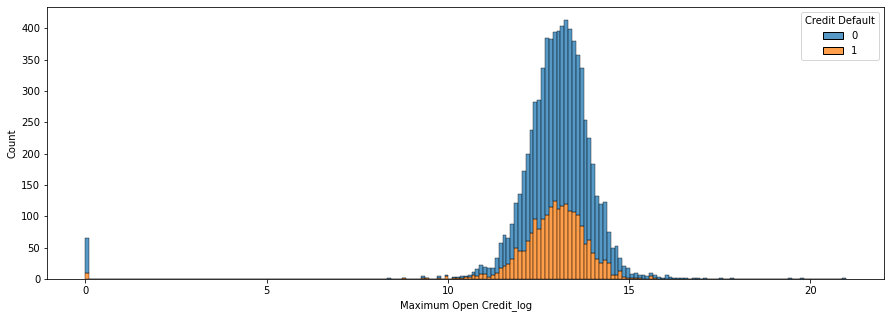

In [450]:
variable_analyze('Maximum Open Credit', number_var, df)
variable_hist_plot('Maximum Open Credit', df)

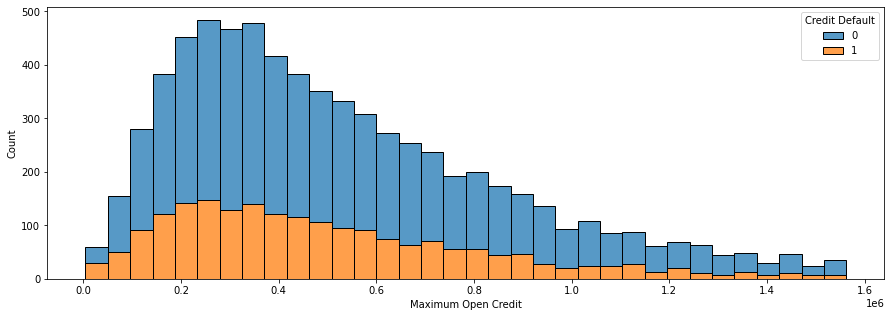

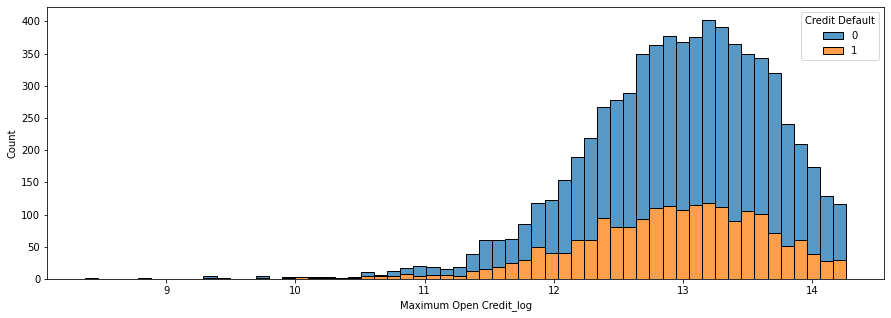

In [451]:
#Посмотрим распределение по значениям > 0 и без выбросов
variable_hist_plot('Maximum Open Credit', df[(df['Maximum Open Credit']>0) & (df['Maximum Open Credit']<=1564909.5)])

In [452]:
df = df[df['Maximum Open Credit'] > 0]

In [453]:
df['Maximum Open Credit log'] = np.log(df['Maximum Open Credit'] + 1)

Замечание:

    Создали новый признак логарифмированием исходного признака без 0-ых значений

#### Number of Open Accounts

Количество null значений у признака: 0

Выбросы признака: 
low_range       -1.0
upper_range     23.0
out_count      170.0
Name: Number of Open Accounts, dtype: float64


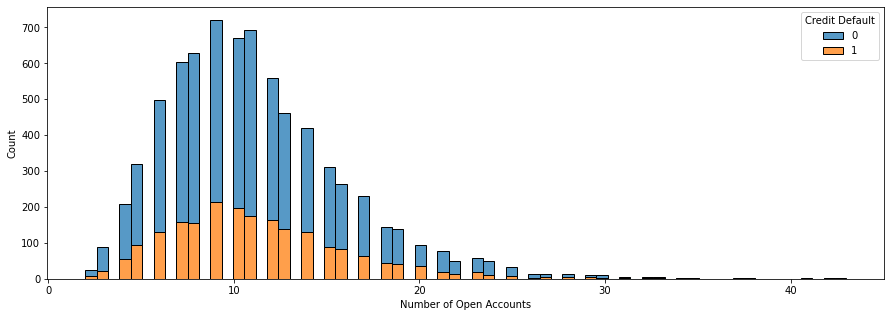

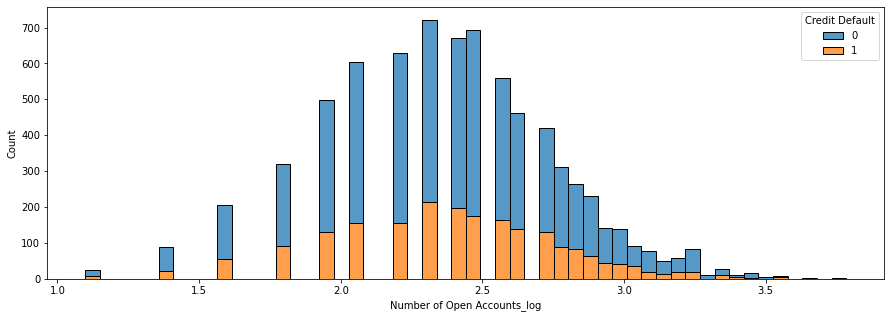

In [454]:
variable_analyze('Number of Open Accounts', number_var, df)
variable_hist_plot('Number of Open Accounts', df)

#### Months since last delinquent

Количество null значений у признака: 4051

Выбросы признака: 
low_range      -35.0
upper_range    101.0
out_count        1.0
Name: Months since last delinquent, dtype: float64


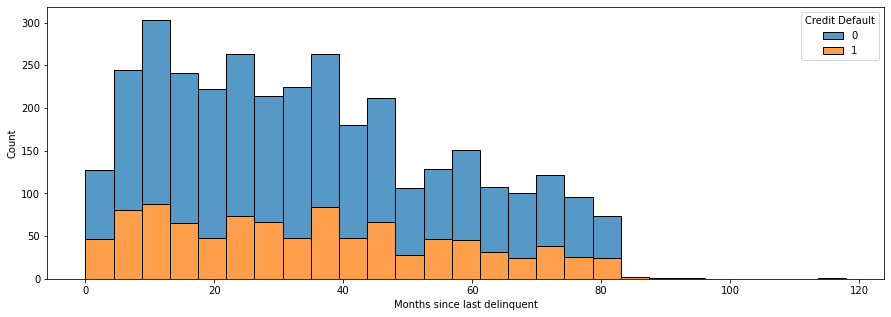

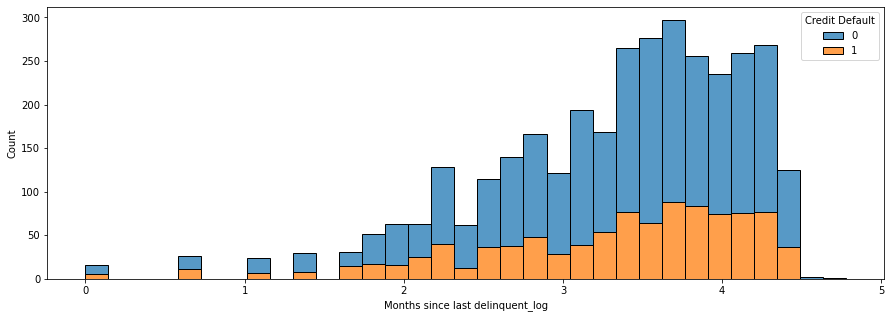

In [455]:
variable_analyze('Months since last delinquent', number_var, df)
variable_hist_plot('Months since last delinquent', df)

Замечание : очень много null значений, скорее всего это те клиенты, у которых нет нарушений. Сделаем преобразование

#### Current Loan Amount

Количество null значений у признака: 0

Выбросы признака: 
low_range      -329197.0
upper_range    1029611.0
out_count          861.0
Name: Current Loan Amount, dtype: float64


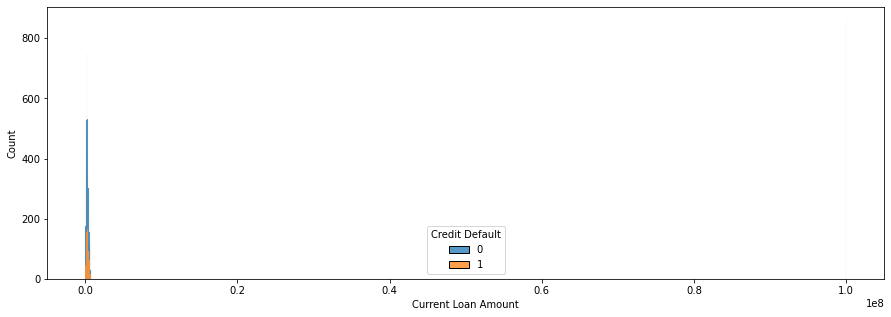

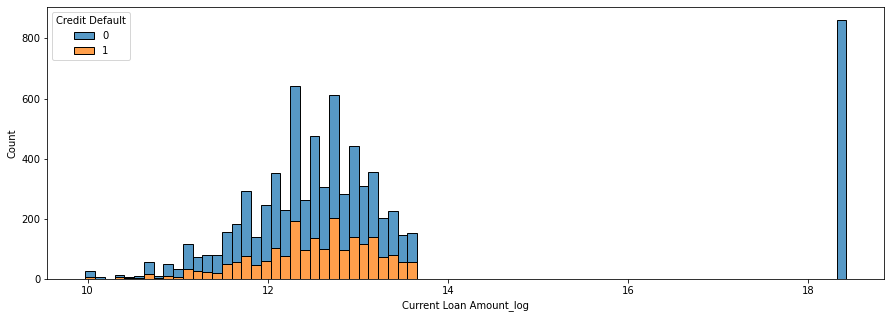

In [456]:
variable_analyze('Current Loan Amount', number_var, df)
variable_hist_plot('Current Loan Amount', df)

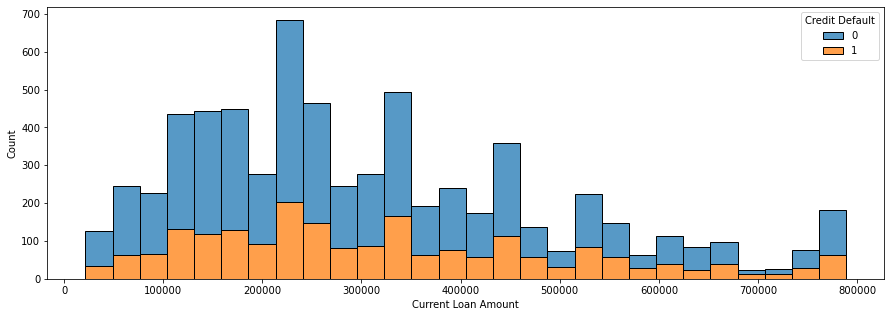

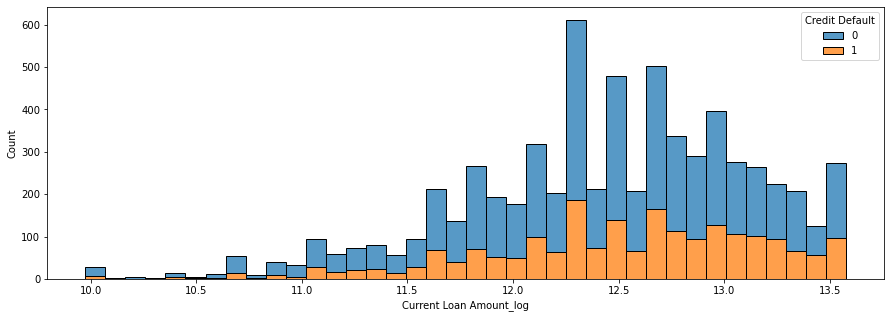

In [457]:
# Так как часть значений 99999999.0 (возможно это заглушкка), ставим посмотрим распределение < 99_999_999
variable_hist_plot('Current Loan Amount', df[df['Current Loan Amount'] < 99_999_999])

In [458]:
df = df[df['Current Loan Amount'] < 99_999_999]

Вывод:
    
    Обрезали признак по значению заглушки

#### Current Credit Balance

Количество null значений у признака: 0

Выбросы признака: 
low_range     -254039.5
upper_range    731832.5
out_count         379.0
Name: Current Credit Balance, dtype: float64


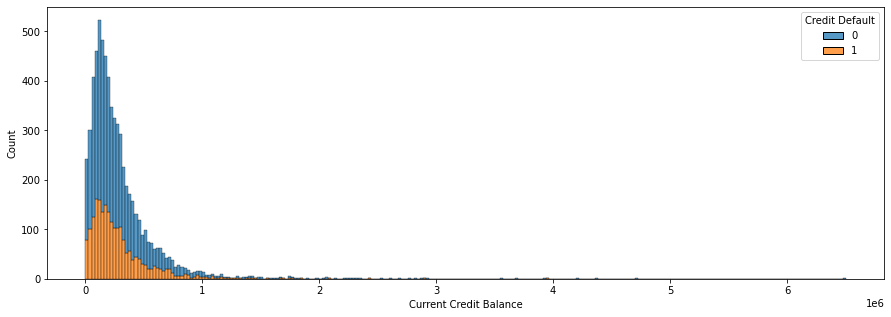

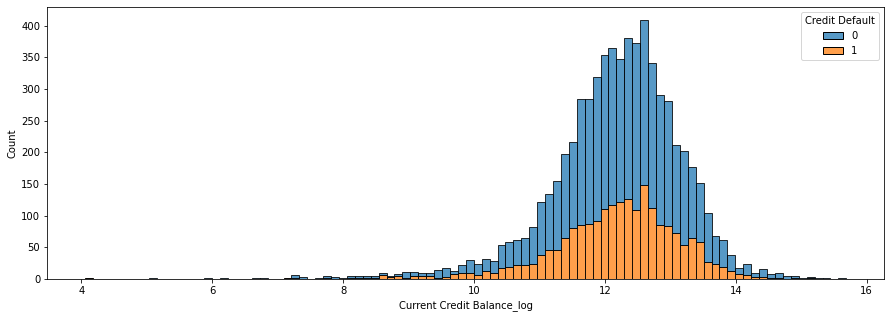

In [459]:
variable_analyze('Current Credit Balance', number_var, df)
variable_hist_plot('Current Credit Balance', df)

In [460]:
df['Current Credit Balance log'] = np.log(df['Current Credit Balance'] + 1)

Вывод:

    Создали новый признак логарифмированием

#### Monthly Debt

Количество null значений у признака: 0

Выбросы признака: 
low_range     -10294.88
upper_range    44408.12
out_count        225.00
Name: Monthly Debt, dtype: float64


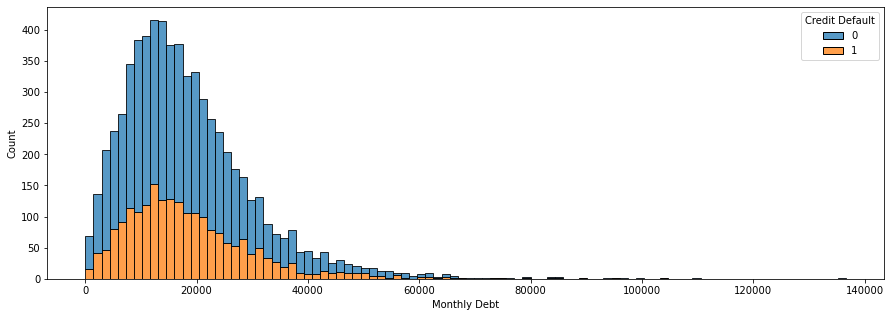

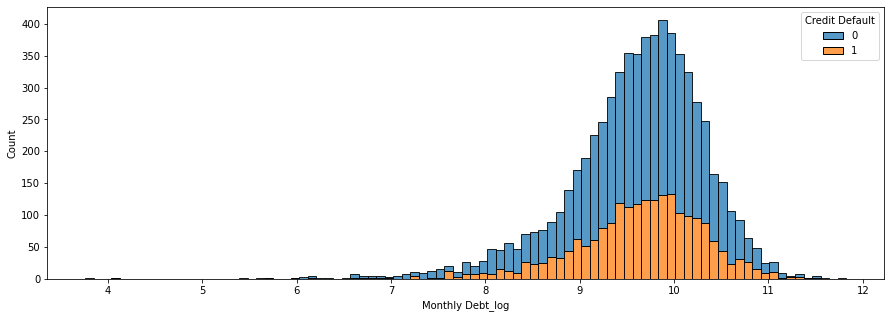

In [461]:
variable_analyze('Monthly Debt', number_var, df)
variable_hist_plot('Monthly Debt', df)

In [462]:
df['Monthly Debt log'] = np.log(df['Monthly Debt'] + 1)

Замечание:

    Создали новый признак логарифмированием

#### Credit Score

Количество null значений у признака: 1535

Выбросы признака: 
low_range      658.0
upper_range    794.0
out_count      604.0
Name: Credit Score, dtype: float64


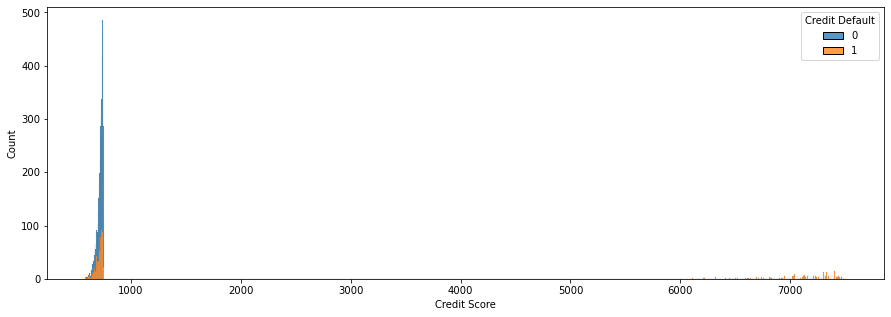

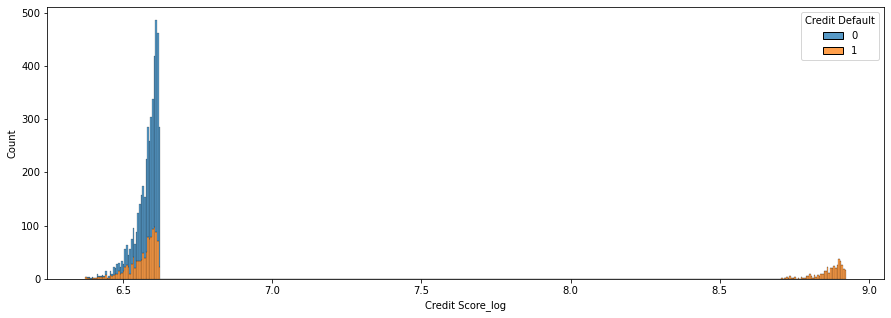

In [463]:
variable_analyze('Credit Score', number_var, df)
variable_hist_plot('Credit Score', df)

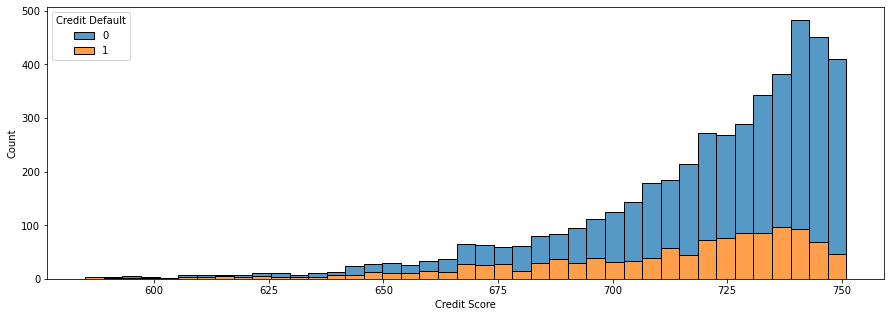

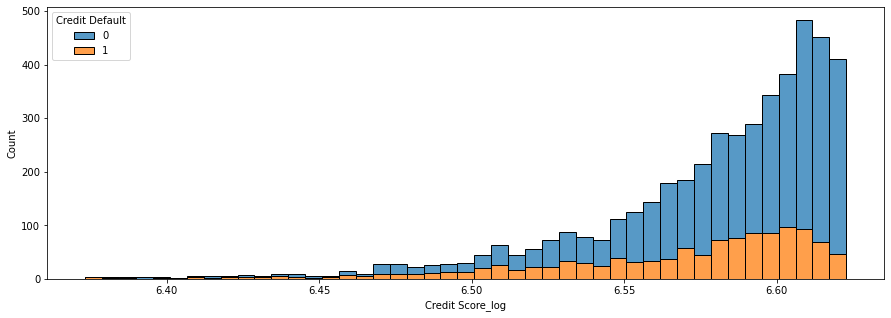

In [464]:
variable_hist_plot('Credit Score', df[df['Credit Score'] < 6000])

In [465]:
# Удалим строки со скором >= 6000
df = df[df['Credit Default'] < 6000]

Вывод:
    
    Часть примеров имеет null значения, скорее всего это новые клиенты, либо клиенты по которым не посчитан скор. 
    Вынести это в отдельный признак
    
    Часть скоров имеет значение > 6000. Скорее всего это ошибка в вычислении скора (она может быть не более 1000, и чем больше скор, тем лучше занчение дефолта должно быть, а у всех записей значение дефолта = 1. Поэтому удалили эти значения

#### Таргет Credit Default

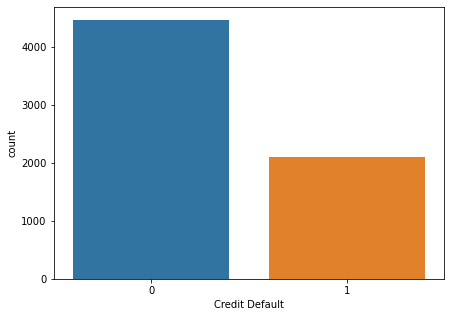

In [466]:
plt.figure(figsize=(7,5))
sns.countplot(x='Credit Default', data=df)
plt.show()

### Обработка NULL значений

In [467]:
df.shape

(6574, 22)

In [468]:
# Обработка null значений
df.isna().sum()

Home Ownership                     0
Annual Income                   1535
Years in current job             328
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    3557
Bankruptcies                       9
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1535
Credit Default                     0
Annual Income log               1535
Years of Credit History log        0
Maximum Open Credit log            0
Current Credit Balance log         0
Monthly Debt log                   0
dtype: int64

In [469]:
df[df['Annual Income'].isna()].isna().sum()

Home Ownership                     0
Annual Income                   1535
Years in current job              75
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent     862
Bankruptcies                       2
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1535
Credit Default                     0
Annual Income log               1535
Years of Credit History log        0
Maximum Open Credit log            0
Current Credit Balance log         0
Monthly Debt log                   0
dtype: int64

Видим, что много записей у других атрибутов, где Annual Income is NULL. Не имеет смысла заменять эти записи. Удалим их

In [470]:
df = df[df['Annual Income'].isna()==False]

In [471]:
df.isna().sum()

Home Ownership                     0
Annual Income                      0
Years in current job             253
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    2695
Bankruptcies                       7
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                       0
Credit Default                     0
Annual Income log                  0
Years of Credit History log        0
Maximum Open Credit log            0
Current Credit Balance log         0
Monthly Debt log                   0
dtype: int64

Видим, что осталось много записей с NULL у Months since last delinquent. 
Сделаем замену. Также выделим новый признак.

Также есть записи с NULL у Years in current job и Bankruptcies. Их немного, сделаем замену.

In [491]:
df['Years in current job'].fillna('10+ years', inplace=True)

df['Without delinquent'] = df['Months since last delinquent'].apply(lambda x: 1 if pd.isna(x) else 0)
df['Months since last delinquent'].fillna(df['Months since last delinquent'].median(), inplace=True)
       
df['Bankruptcies'].fillna(0, inplace=True)

In [492]:
#Добавим новые признаки в списки категорий
for var in ['Annual Income log', 'Years of Credit History log', 
            'Maximum Open Credit log', 'Current Credit Balance log', 'Monthly Debt log']:
    number_var.append(var)
    
bin_var.append('Without delinquent')

### Работа с признаками

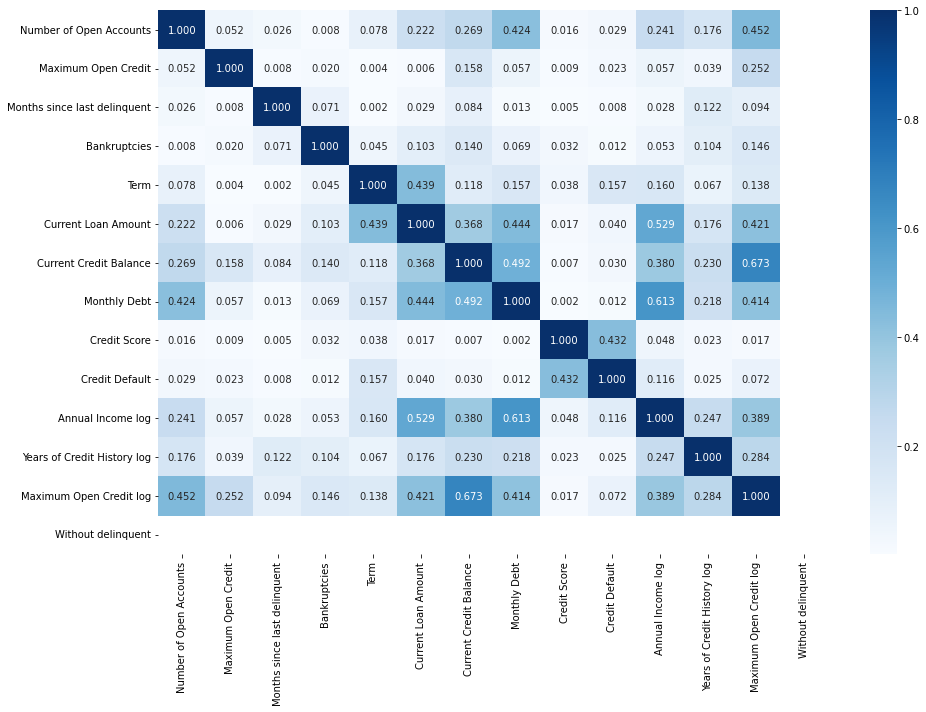

In [493]:
#Корреляция признаков

plt.figure(figsize=(15,10))
sns.heatmap(df.corr().abs(), annot=True, fmt='.3f', cmap="Blues")
plt.show()

Видим, что часть признаков сильно коррелирует друг с другом удалим часть из них:
        

In [477]:
df = df.drop(['Annual Income', 'Years of Credit History', 'Current Credit Balance log', 'Monthly Debt log'], axis=1)

KeyError: "['Annual Income' 'Years of Credit History' 'Current Credit Balance log'\n 'Monthly Debt log'] not found in axis"

In [479]:
for var in ['Years of Credit History', 'Annual Income', 'Current Credit Balance log', 'Monthly Debt log']:
    number_var.remove(var)

### Выделение новых признаков

In [480]:
print("Binary variables:", bin_var, "Categorial variables:", categorial_var, "Number variables:", number_var, sep='\n')

Binary variables:
['Term', 'Without delinquent']
Categorial variables:
['Home Ownership', 'Years in current job', 'Tax Liens', 'Number of Credit Problems', 'Bankruptcies', 'Purpose']
Number variables:
['Number of Open Accounts', 'Maximum Open Credit', 'Months since last delinquent', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score', 'Annual Income log', 'Years of Credit History log', 'Maximum Open Credit log']


In [481]:
X = df[[*bin_var, *categorial_var, *number_var]]
y = df['Credit Default']

#Выделим трейн и тест
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)
#Выделим отдельно трейн и валид для корректировки моделей
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=RANDOM_SEED)

#Выделим массивы без обработки для проверки доп критериев
df_train = X_train.copy()
df_test = X_test.copy()

### Преобразование признаков

In [482]:
X_train_bin = X_train[bin_var]
X_test_bin = X_test[bin_var]
X_val_bin = X_val[bin_var]

X_train_num = X_train[number_var]
X_test_num = X_test[number_var]
X_val_num = X_val[number_var]

X_train_cat = X_train[categorial_var]
X_test_cat = X_test[categorial_var]
X_val_cat = X_val[categorial_var]

#StandardScaler
stand_scaler = StandardScaler()
X_train_num = stand_scaler.fit_transform(X_train_num)
X_test_num = stand_scaler.transform(X_test_num)
X_val_num = stand_scaler.transform(X_val_num)

#RareLabelEncoder
rle = RareLabelEncoder(tol=0.03, n_categories=2, replace_with='Rare')
X_train_cat = rle.fit_transform(X_train_cat, y_train)
X_test_cat = rle.transform(X_test_cat)
X_val_cat = rle.transform(X_val_cat)

#WOEEncoder
woe = WOEEncoder(random_state=RANDOM_SEED)
X_train_cat = woe.fit_transform(X_train_cat, y_train)
X_test_cat = woe.transform(X_test_cat)
X_val_cat = woe.transform(X_val_cat)

# Объединим обратно категориальные и числовые датасеты
X_train = np.hstack((X_train_bin, X_train_num, X_train_cat))
X_test = np.hstack((X_test_bin, X_test_num, X_test_cat))
X_val = np.hstack((X_val_bin, X_val_num, X_val_cat))

### PSI

In [483]:
print("Значения PSI для числовых признаков\n")

for var in number_var:
    psi_var = calculate_psi(df_train[var], df_test[var])
    print(f"{var:30s}: {psi_var:.5f}")

Значения PSI для числовых признаков

Number of Open Accounts       : 0.00800
Maximum Open Credit           : 0.00271
Months since last delinquent  : 0.00771
Current Loan Amount           : 0.01151
Current Credit Balance        : 0.01496
Monthly Debt                  : 0.01170
Credit Score                  : 0.00599
Annual Income log             : 0.00848
Years of Credit History log   : 0.00691
Maximum Open Credit log       : 0.00546


### LogisticRegression

In [484]:
#LogisticRegression Модель без оптимизации
lr_model = LogisticRegression(random_state=RANDOM_SEED).fit(X_train, y_train)
lr_prb = lr_model.predict_proba(X_test)[:, 1]

In [57]:
#LogisticRegression Модель с оптимизацией гиперпараметров
lr_model = LogisticRegression(random_state=RANDOM_SEED)

param_grid = {
    'solver': ['liblinear', 'saga'],  
    'penalty': ['l1','l2'],
    'tol': (1e-5, 1e-3, 'log-uniform'),
    'C': (10, 100, 'log-uniform'),
    'fit_intercept': [True, False]
}

opt = BayesSearchCV(
    lr_model,
    param_grid,
    random_state=RANDOM_SEED,
    cv=3
)

In [58]:
opt.fit(X_train, y_train)
opt.best_params_

OrderedDict([('C', 10),
             ('fit_intercept', True),
             ('penalty', 'l1'),
             ('solver', 'saga'),
             ('tol', 1.1360828903750424e-05)])

In [59]:
lr_model = LogisticRegression(**opt.best_params_, random_state=RANDOM_SEED).fit(X_train, y_train)
lr_prb = lr_model.predict_proba(X_test)[:, 1]

#### Feature importance

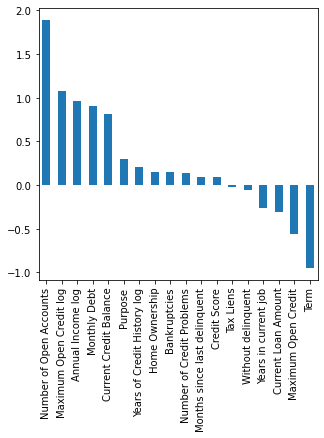

In [485]:
#feature importance
lr_imp = pd.Series(lr_model.coef_[0], index=df_train.columns)

plt.figure(figsize=(5,5))
lr_imp.sort_values(ascending=False).plot.bar()
plt.show()

#### Оценка качества модели

#### Индекс Джини и интервальный Джини

In [486]:
#Коэффициент Джини
gini_x = round(gini(lr_prb), 3)
print(f"Значение коэффициента Джини: {gini_x}")

Значение коэффициента Джини: 0.349


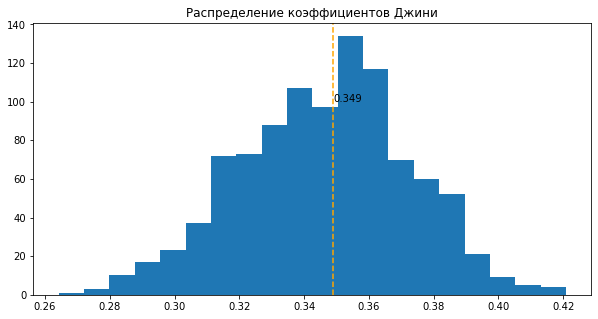

In [487]:
# интервальный Джини
gini_interv = interval_gini(lr_prb)

#Построим график распределения индексов Джини
plt.figure(figsize=(10,5))
plt.hist(gini_interv, bins=20)
plt.axvline(x=gini_x, color='orange', linestyle="--") 
plt.text (gini_x, 100, gini_x)
plt.title('Распределение коэффициентов Джини')
plt.show()

#### Оценка Колмогорова-Смирнова

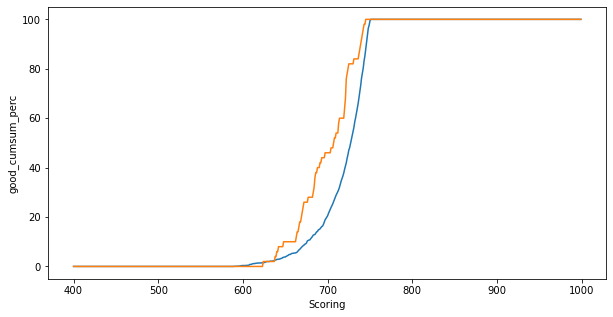

KstestResult(statistic=0.058333333333333334, pvalue=0.25920433878059906)

In [488]:
model_ks_test(lr_prb, df_test)

#### Изотоническая калибровка и график сравнения

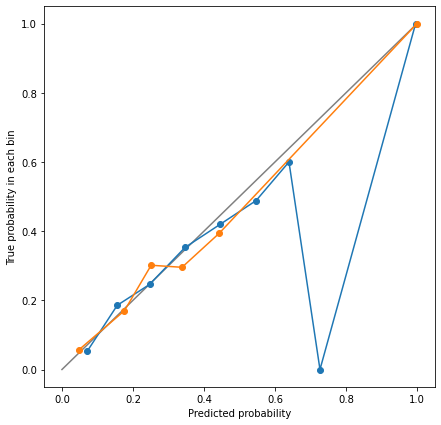

In [489]:
model_calibr_curve(lr_model, lr_prb, y_test, X_val, y_val)

### SVM модель

In [401]:
#SVM Модель без оптимизации
svc_model = SVC(probability=True, random_state=RANDOM_SEED).fit(X_train, y_train)
svc_prb = svc_model.predict_proba(X_test)[:, 1]

In [74]:
#SVM Модель с оптимизацией гиперпараметров
svc_model = SVC(probability=True, random_state=RANDOM_SEED)

param_grid = {
    'C': (1e-6, 100.0, 'log-uniform'),
#    'degree': (1, 5),
#    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': [1e-6, 100.0, 'log-uniform']
}


opt = BayesSearchCV(
    svc_model,
    param_grid,
    random_state=RANDOM_SEED,
    cv=3
)

In [75]:
opt.fit(X_train, y_train)
opt.best_params_

OrderedDict([('C', 83.36992814578494), ('gamma', 0.014289381660687528)])

In [77]:
svc_model = SVC(**opt.best_params_, probability=True, random_state=RANDOM_SEED).fit(X_train, y_train)
svc_prb = svc_model.predict_proba(X_test)[:, 1]

#### Feature importance

In [402]:
#feature importance
if svc_model.kernel == 'linear':
    svc_imp = pd.Series(svc_model.coef_, index=df_train.columns)

    plt.figure(figsize=(5,5))
    svc_imp.sort_values(ascending=False).plot.bar()
    plt.show()
else:
    print("Feature importance works only for SVM with linear kernel")

Feature importance works only for SVM with linear kernel


#### Коэффициент Джини и интервальный Джини

In [403]:
gini_x = round(gini(svc_prb), 3)
print(f"Значение коэффициента Джини: {gini_x}")

Значение коэффициента Джини: 0.235


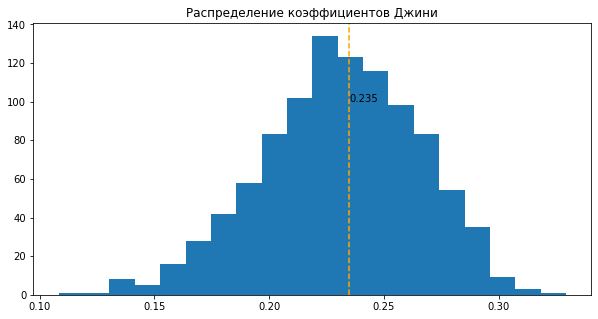

In [404]:
# интервальный Джини
gini_interv = interval_gini(svc_prb)

#Построим график распределения индексов Джини
plt.figure(figsize=(10,5))
plt.hist(gini_interv, bins=20)
plt.axvline(x=gini_x, color='orange', linestyle="--") 
plt.text (gini_x, 100, gini_x)
plt.title('Распределение коэффициентов Джини')
plt.show()

#### Оценка Колмогорова-Смирнова

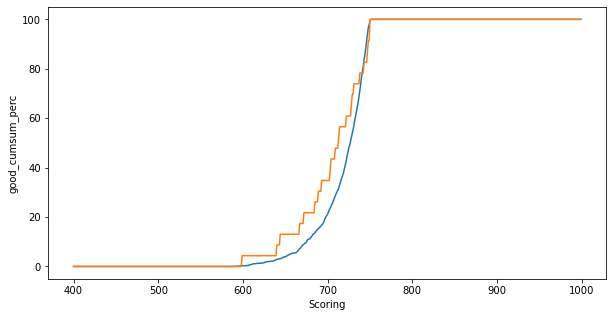

KstestResult(statistic=0.09, pvalue=0.015461976883100177)

In [405]:
model_ks_test(svc_prb, df_test)

#### Изотоническая калибровка и график сравнения

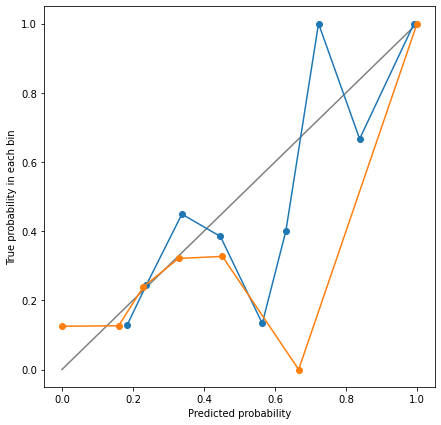

In [406]:
model_calibr_curve(svc_model, svc_prb, y_test, X_val, y_val)

### Random Forest

In [82]:
#RandomForestClassifier Модель без оптимизации
rfc_model = RandomForestClassifier(random_state=RANDOM_SEED).fit(X_train, y_train)
rfc_prb = rfc_model.predict_proba(X_test)[:, 1]

In [83]:
#RandomForestClassifier Модель с оптимизацией гиперпараметров
rfc_model = RandomForestClassifier(random_state=RANDOM_SEED)

param_grid = {
        'n_estimators': (5,1000),
#        'max_features': ['auto','sqrt'],
        'max_depth': (2,90),
        'min_samples_split': (2,10),
#        'min_samples_leaf': (1,7),
        'bootstrap': ["True","False"]
}

opt = BayesSearchCV(
    rfc_model,
    param_grid,
    random_state=RANDOM_SEED,
    cv=3
)

In [84]:
opt.fit(X_train, y_train)
opt.best_params_

OrderedDict([('bootstrap', 'False'),
             ('max_depth', 12),
             ('min_samples_split', 10),
             ('n_estimators', 51)])

In [85]:
rfc_model = RandomForestClassifier(**opt.best_params_, random_state=RANDOM_SEED).fit(X_train, y_train)
rfc_prb = rfc_model.predict_proba(X_test)[:, 1]

#### Feature importance Gini

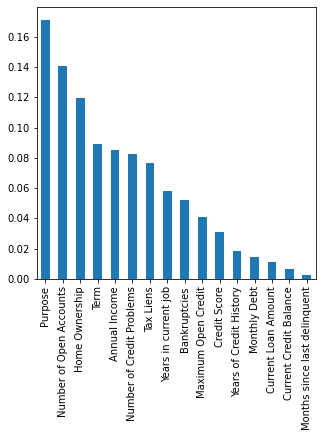

In [106]:
#Gini importance
rfc_imp = pd.Series(rfc_model.feature_importances_, index=df_train.columns)

plt.figure(figsize=(5,5))
rfc_imp.sort_values(ascending=False).plot.bar()
plt.show()

#### Коэффициент Джини

In [107]:
gini_x = round(gini(rfc_prb), 3)
print(f"Значение коэффициента Джини: {gini_x}")

Значение коэффициента Джини: 0.336


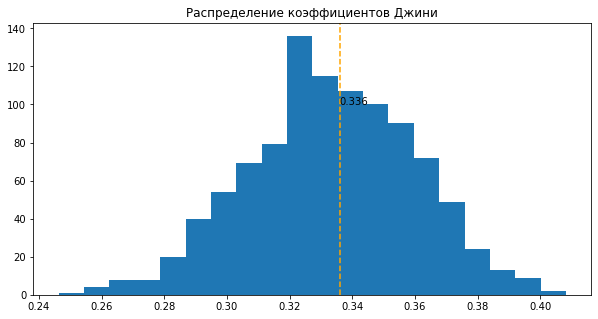

In [108]:
# интервальный Джини
gini_interv = interval_gini(rfc_prb)

#Построим график распределения индексов Джини

plt.figure(figsize=(10,5))
plt.hist(gini_interv, bins=20)
plt.axvline(x=gini_x, color='orange', linestyle="--") 
plt.text (gini_x, 100, gini_x)
plt.title('Распределение коэффициентов Джини')
plt.show()

#### Оценка Колмогорова-Смирнова

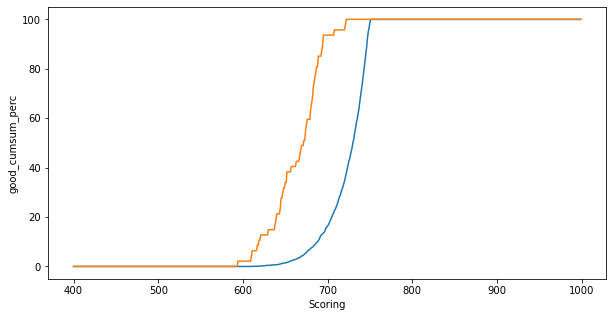

KstestResult(statistic=0.12, pvalue=0.00034899222851716977)

In [109]:
model_ks_test(rfc_prb, df_test)

#### Изотоническая калибровка и график сравнения

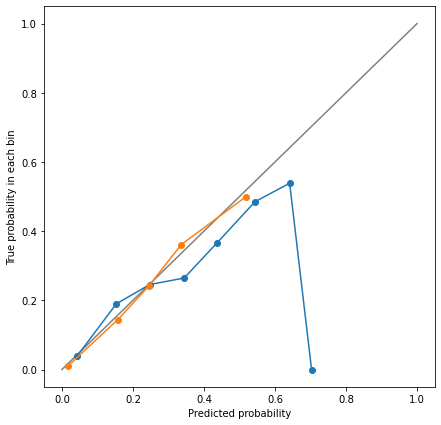

In [110]:
model_calibr_curve(rfc_model, rfc_prb, y_test, X_val, y_val)

### LGBMClassifier

In [111]:
#LGBMClassifier Модель без оптимизации
lgbmc_model = LGBMClassifier(importance_type='gain', random_state=RANDOM_SEED).fit(X_train, y_train)
lgbmc_prb = lgbmc_model.predict_proba(X_test)[:, 1]

In [112]:
#LGBMClassifier Модель с оптимизацией гиперпараметров
lgbmc_model = LGBMClassifier(importance_type='gain', random_state=RANDOM_SEED)

param_grid = {
        'learning_rate': (0.01, 1.0, 'log-uniform'),
        'num_leaves': (2, 100),
        'max_depth': (0, 100),
        'n_estimators': (10, 1000),
}

opt = BayesSearchCV(
    lgbmc_model,
    param_grid,
    random_state=RANDOM_SEED,
    cv=3
)

In [113]:
opt.fit(X_train, y_train)
opt.best_params_

OrderedDict([('learning_rate', 0.026790533576124733),
             ('max_depth', 0),
             ('n_estimators', 428),
             ('num_leaves', 2)])

In [115]:
lgbmc_model = LGBMClassifier(**opt.best_params_, importance_type='gain', random_state=RANDOM_SEED).fit(X_train, y_train)
lgbmc_prb = lgbmc_model.predict_proba(X_test)[:, 1]

#### Feature importance Gain (Gini)

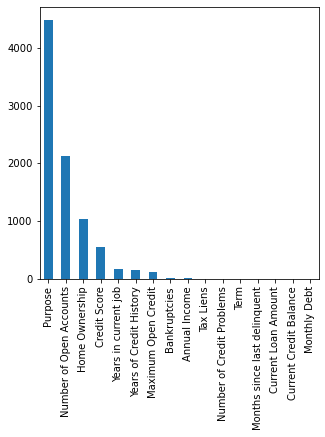

In [117]:
lgbmc_imp = pd.Series(lgbmc_model.feature_importances_, index=df_train.columns)

plt.figure(figsize=(5,5))
lgbmc_imp.sort_values(ascending=False).plot.bar()
plt.show()

#### Коэффициент Джини

In [118]:
gini_x = round(gini(lgbmc_prb), 3)
print(f"Значение коэффициента Джини: {gini_x}")

Значение коэффициента Джини: 0.317


#### Оценка Колмогорова-Смирнова

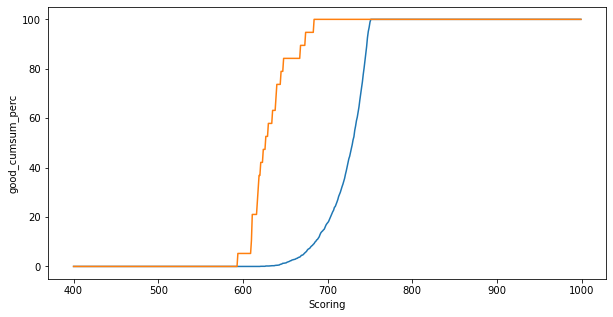

KstestResult(statistic=0.175, pvalue=1.9336585428696407e-08)

In [119]:
model_ks_test(lgbmc_prb, df_test)

#### Интервальный Джини

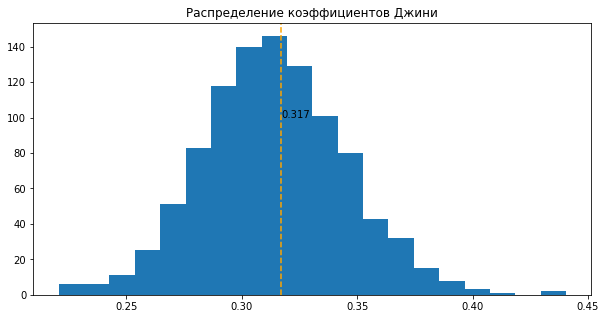

In [120]:
gini_interv = interval_gini(lgbmc_prb)

#Построим график распределения индексов Джини
plt.figure(figsize=(10,5))
plt.hist(gini_interv, bins=20)
plt.axvline(x=gini_x, color='orange', linestyle="--") 
plt.text (gini_x, 100, gini_x)
plt.title('Распределение коэффициентов Джини')
plt.show()

#### Изотоническая калибровка и график сравнения

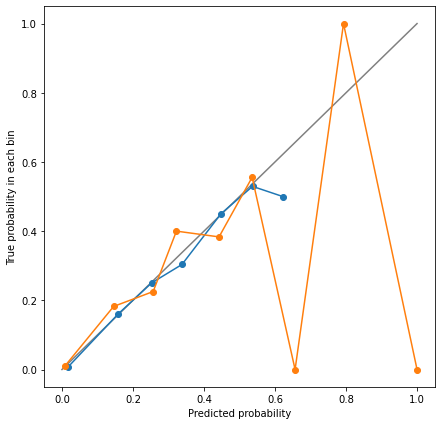

In [121]:
model_calibr_curve(lgbmc_model, lgbmc_prb, y_test, X_val, y_val)

# Сделать один график для всех моделей